## 1. Аналитический отчет для HR-отдела

Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL.

**Примеры гипотез:**
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.


Таблицы, доступные для анализа: `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [2]:
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.tseries.offsets import MonthEnd

import requests
import re
import pymorphy2
import json

In [7]:
pg_connection = json.load(open('pg_config.json')) # параметры для подключения к внешней базе данных

In [46]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

## Проверка таблиц данных 

In [14]:
# Создание запроса к базе данных для получения списка доступных таблиц

query = """SELECT table_name
           FROM information_schema.tables
           WHERE table_schema='public';
        """

cursor.execute(query)
# Получение всех данных по запросу и превращение в обычный список
tables = [x[0] for x in cursor.fetchall()]
# Сохранение изменений
# conn.commit()
# Таблицы в базе human_resources
tables, len(tables)

(['manager_id',
  'hr_dataset',
  'recruiting_costs_rb',
  'production_staff',
  'recruiting_costs',
  'hr_dataset_1',
  'salary_grid',
  'source_employee',
  'recruiting_costs_1',
  'salary_grid_1',
  'amount_emps_1',
  'production_staff_new',
  'new_production_staff',
  'production_staff_rebuilded',
  'hr_dataset_rebuilded',
  'tmpDB',
  'amount_emps',
  'recruiting_costs_rebuilded',
  'salary_grid_rebuilded',
  'manager',
  'amount_emps_rebuilded'],
 21)

На данном этапе мы выяснили, что в базе всего 21 таблица, и четыре из них, доступных для анализа по условиям задания, присутствуют.

Далее для составления набора предметов исследований и выдвижения каких-либо гипотез, узнаем общий объем данных и названия полей таблиц с примерами заполнений.

In [27]:
def get_table_data(table_name):
    query = "SELECT COUNT(*) FROM {}".format(table_name)
    cursor.execute(query)
    row = cursor.fetchone()
    print("Кол-во записей: %s" % row)

    query = """SELECT column_name
               FROM information_schema.columns
               WHERE table_name = '{}';
            """.format(table_name)
    cursor.execute(query)
    rows = [x[0] for x in cursor.fetchall()]
    print("Поля таблицы:\n%s" % '\n'.join(rows))

    return pd.read_sql("SELECT * FROM {} LIMIT 5;".format(table_name), conn)

### Таблица `hr_dataset`

In [28]:
hr_dataset_df = get_table_data('hr_dataset')
hr_dataset_df

Кол-во записей: 310
Поля таблицы:
id
Employee Name
Employee Number
marriedid
maritalstatusid
genderid
empstatus_id
deptid
perf_scoreid
age
Pay Rate
state
zip
dob
sex
maritaldesc
citizendesc
Hispanic/Latino
racedesc
Date of Hire
Days Employed
Date of Termination
Reason For Term
Employment Status
department
position
Manager Name
Employee Source
Performance Score


,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review


### Таблица `production_staff`

In [31]:
production_staff_df = get_table_data('production_staff')
production_staff_df

Кол-во записей: 256
Поля таблицы:
id
Employee Name
Race Desc
Date of Hire
TermDate
Reason for Term
Employment Status
Department
Position
Pay
Manager Name
Performance Score
Abutments/Hour Wk 1
Abutments/Hour Wk 2
Daily Error Rate
90-day Complaints


,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0,0,0,0
1,2,"Bozzi, Charles",Asian,2013-09-30,2014-08-07,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0,0,0,0
2,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0,0,0,0
3,4,"Dunn, Amy",White,2014-09-18,None,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0,0,0,0
4,5,"Gray, Elijiah",White,2015-06-02,None,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0,0,0,0


### Таблица `recruiting_costs`

In [30]:
recruiting_costs_df = get_table_data('recruiting_costs')
recruiting_costs_df

Кол-во записей: 22
Поля таблицы:
id
Employment Source
January 
February
March
April
May
June
July
August
September
October
November
December
Total


,id,Employment Source,January,February,March,April,May,June,July,August,September,October,November,December,Total
0,1,Billboard,520,520,520,520,0,0,612,612,729,749,910,500,6192
1,2,Careerbuilder,410,410,410,820,820,410,410,820,820,1230,820,410,7790
2,3,Company Intranet - Partner,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Diversity Job Fair,0,5129,0,0,0,0,0,4892,0,0,0,0,10021
4,5,Employee Referral,0,0,0,0,0,0,0,0,0,0,0,0,0


## Таблица `salary_grid`

In [32]:
salary_grid_df = get_table_data('salary_grid')
salary_grid_df

Кол-во записей: 12
Поля таблицы:
id
Position
Salary Min
Salary Mid
Salary Max
Hourly Min
Hourly Mid
Hourly Max


,id,Position,Salary Min,Salary Mid,Salary Max,Hourly Min,Hourly Mid,Hourly Max
0,1,Administrative Assistant,30000,40000,50000,14.42,19.23,24.04
1,2,Sr. Administrative Assistant,35000,45000,55000,16.83,21.63,26.44
2,3,Accountant I,42274,51425,62299,20.32,24.72,29.95
3,4,Accountant II,50490,62158,74658,24.27,29.88,35.89
4,5,Sr. Accountant,63264,76988,92454,30.42,37.01,44.45


## 1. Есть ли зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник?

In [58]:
curs = conn.cursor()
curs.execute("ROLLBACK")
conn.commit()

###  Таблица `hr_dataset`

In [60]:
query = """SELECT COUNT(DISTINCT "Manager Name") FROM hr_dataset;"""
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("Кол-во менеджеров: %s" % row)

# менеджеры
query = """SELECT DISTINCT "Manager Name" FROM hr_dataset;"""
cursor.execute(query)
rows = cursor.fetchall()
conn.commit()
print(*[x[0] for x in rows], sep='\n')

query = """SELECT COUNT(DISTINCT "Performance Score") FROM hr_dataset;"""
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("\nКол-во вариантов оценок: %s" % row)

# Оценки
query = """SELECT DISTINCT "Performance Score" FROM hr_dataset;"""
cursor.execute(query)
rows = cursor.fetchall()
conn.commit()
print(*[x[0] for x in rows], sep='\n')

Кол-во менеджеров: 21
Brian Champaigne
Michael Albert
Simon Roup
John Smith
Amy Dunn
Brannon Miller
Webster Butler
Brandon R. LeBlanc
Janet King
Lynn Daneault
Elijiah Gray
Alex Sweetwater
David Stanley
Peter Monroe
Eric Dougall
Jennifer Zamora
Board of Directors
Kelley Spirea
Kissy Sullivan
Ketsia Liebig
Debra Houlihan

Кол-во вариантов оценок: 7
Exceptional
90-day meets
N/A- too early to review
Fully Meets
Exceeds
PIP
Needs Improvement


In [62]:
df_hr_dataset_mn_ps = pd.read_sql("""SELECT
                                       "Manager Name"
                                       , "Performance Score"
                                       , COUNT("Performance Score") AS "PS Count"
                                     FROM hr_dataset
                                     GROUP BY 1, 2
                                     ORDER BY 1, 3 DESC;""", conn)
df_hr_dataset_mn_ps

,Manager Name,Performance Score,PS Count
0,Alex Sweetwater,Fully Meets,4
1,Alex Sweetwater,90-day meets,2
2,Alex Sweetwater,Exceeds,1
3,Alex Sweetwater,Needs Improvement,1
4,Alex Sweetwater,Exceptional,1
...,...,...,...
81,Webster Butler,Fully Meets,11
82,Webster Butler,N/A- too early to review,3
83,Webster Butler,90-day meets,3
84,Webster Butler,Exceeds,2


###  Таблица `production_staff`

In [63]:
query = """SELECT COUNT(DISTINCT "Manager Name") FROM production_staff;"""
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("Кол-во менеджеров: %s" % row)

# менеджеры
query = """SELECT DISTINCT "Manager Name" FROM production_staff;"""
cursor.execute(query)
rows = cursor.fetchall()
conn.commit()
print(*[x[0] for x in rows], sep='\n')

query = """SELECT COUNT(DISTINCT "Performance Score") FROM production_staff;"""
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("\nКол-во вариантов оценок: %s" % row)

# Оценки
query = """SELECT DISTINCT "Performance Score" FROM production_staff;"""
cursor.execute(query)
rows = cursor.fetchall()
conn.commit()
print(*[x[0] for x in rows], sep='\n')

Кол-во менеджеров: 10
Ketsia Liebig
Amy Dunn
None
Brannon Miller
Webster Butler
Michael Albert
Elijiah Gray
David Stanley
Elisa Bramante
Kelley Spirea
Kissy Sullivan

Кол-во вариантов оценок: 7
Needs Improvement
None
Exceptional
90-day meets
N/A- too early to review
Fully Meets
Exceeds
PIP


In [64]:
df_production_staff_mn_ps = pd.read_sql("""SELECT
                                            "Manager Name"
                                            , "Performance Score"
                                            , COUNT("Performance Score") AS "PS Count"
                                           FROM production_staff
                                           GROUP BY 1, 2
                                           ORDER BY 1, 3 DESC;""", conn)
df_production_staff_mn_ps

,Manager Name,Performance Score,PS Count
0,Amy Dunn,Fully Meets,11
1,Amy Dunn,N/A- too early to review,5
2,Amy Dunn,Exceeds,2
3,Amy Dunn,Exceptional,1
4,Amy Dunn,90-day meets,1
5,Amy Dunn,PIP,1
6,Brannon Miller,Fully Meets,8
7,Brannon Miller,Exceeds,5
8,Brannon Miller,PIP,4
9,Brannon Miller,Exceptional,2


Существуют две таблицы `hr_dataset` и `production_staff` с заданными по условию полями `Manager Name` и `Performance Score`. Почти все менеджеры из таблицы `production_staff` присутствуют в таблице `hr_dataset` за исключением Elisa Bramante.

In [66]:
query = """SELECT
             DISTINCT hr_dataset."Manager Name"
             , production_staff."Manager Name"
           FROM hr_dataset, production_staff
           WHERE ARRAY[production_staff."Manager Name"] <@ ARRAY[hr_dataset."Manager Name"];
        """
df_managers_repeat = pd.read_sql(query, conn)
df_managers_repeat

,Manager Name,Manager Name
0,Kissy Sullivan,Kissy Sullivan
1,David Stanley,David Stanley
2,Michael Albert,Michael Albert
3,Amy Dunn,Amy Dunn
4,Kelley Spirea,Kelley Spirea
5,Brannon Miller,Brannon Miller
6,Elijiah Gray,Elijiah Gray
7,Ketsia Liebig,Ketsia Liebig
8,Webster Butler,Webster Butler


Подтверждаем, что данные таблиц по оценке работников менеджерами частично пересекаются.

In [67]:
query = """SELECT
             production_staff."Manager Name"
             , production_staff."Employee Name"
             , production_staff."Performance Score"
           FROM production_staff
           EXCEPT -- Разность множеств
           SELECT
             hr_dataset."Manager Name"
             , hr_dataset."Employee Name"
             , hr_dataset."Performance Score"
           FROM hr_dataset;
         """
df_production_staff_difference = pd.read_sql(query, conn)
df_production_staff_difference

,Manager Name,Employee Name,Performance Score
0,Elijiah Gray,"King, Janet",Fully Meets
1,Elisa Bramante,"Liebig, Ketsia",Exceeds
2,Elisa Bramante,"Dunn, Amy",Fully Meets
3,Elisa Bramante,"Bozzi, Charles",Fully Meets
4,Elisa Bramante,"Immediato, Walter",Needs Improvement
5,None,None,None
6,Elisa Bramante,"Gray, Elijiah",Fully Meets
7,Michael Albert,"Sweetwater, Alex",Fully Meets
8,David Stanley,"Monkfish, Erasumus",Fully Meets
9,Elisa Bramante,"Wallace, Courtney E",Fully Meets


Для полной картины о данных зависимости показателей сотрудников от руководящих менеджеров объединим таблицы.

In [68]:
df_hr_dataset_window = pd.read_sql("""SELECT
                                        DISTINCT "Manager Name"
                                        , "Performance Score"
                                        , COUNT("Performance Score")
                                      OVER (PARTITION BY "Manager Name", "Performance Score")
                                      FROM hr_dataset
                                      ORDER BY 1, 2;
                                   """, conn)
df_hr_dataset_window

,Manager Name,Performance Score,count
0,Alex Sweetwater,90-day meets,2
1,Alex Sweetwater,Exceeds,1
2,Alex Sweetwater,Exceptional,1
3,Alex Sweetwater,Fully Meets,4
4,Alex Sweetwater,Needs Improvement,1
...,...,...,...
81,Webster Butler,90-day meets,3
82,Webster Butler,Exceeds,2
83,Webster Butler,Fully Meets,11
84,Webster Butler,N/A- too early to review,3


In [74]:
query = """SELECT
             hr."Manager Name"
             , hr."Performance Score"
             , COUNT(hr."Performance Score") AS Total
           FROM (SELECT
                   "Manager Name"
                   , "Employee Name"
                   , "Performance Score"
                 FROM production_staff
           UNION
           SELECT
             "Manager Name"
             , "Employee Name"
             , "Performance Score" FROM hr_dataset) AS hr
           GROUP BY 1, 2
           HAVING COUNT(hr."Performance Score") > 0
           ORDER BY 3 DESC; 
         """
df_mn_ps = pd.read_sql(query, conn)
df_mn_ps

,Manager Name,Performance Score,total
0,David Stanley,Fully Meets,16
1,Kelley Spirea,Fully Meets,15
2,Ketsia Liebig,Fully Meets,14
3,Elijiah Gray,Fully Meets,14
4,Kissy Sullivan,Fully Meets,14
...,...,...,...
84,Debra Houlihan,Needs Improvement,1
85,David Stanley,Exceeds,1
86,Jennifer Zamora,Exceptional,1
87,Janet King,Exceptional,1


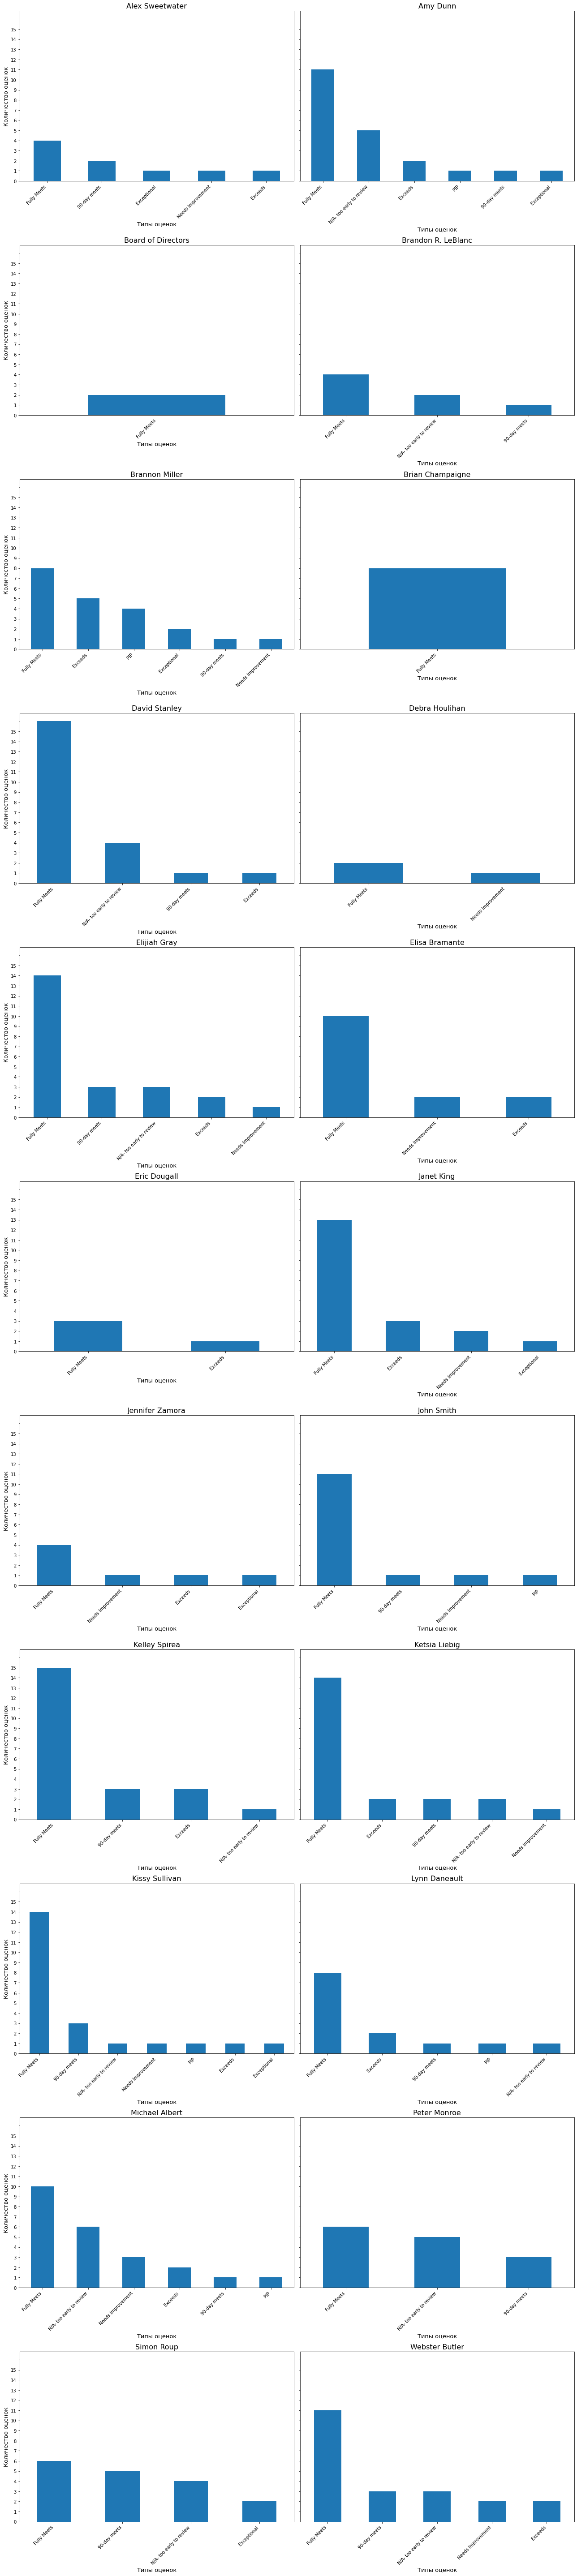

In [75]:
figure, axes = plt.subplots(11, 2, sharey=True, figsize=(18, 80))
# Вывод циклом 22 графиков: формирование групп данных и наложение каждой на соответсвующий график методом zip
for (n, g), ax in zip(df_mn_ps.groupby('Manager Name'), axes.flatten()):
    g.plot.bar(x='Performance Score', ax=ax, legend=False, fontsize=10)
    ax.set_title(n, fontsize=16)
    ax.set_xlabel('Типы оценок', fontsize=13)
    ax.set_ylabel('Количество оценок', fontsize=13)
    ax.set_yticks(range(0, 16, 1))
    ax.set_xticklabels(list(g['Performance Score']), rotation=45, ha='right')
    plt.tight_layout()

Исходя из полученных данных, можно сделать выводы для каждого менеджера: сколько новых сотрудников, величина штата (кто работает недавно или мало / много или давно), у каких сотрудников лучше успеваемость, а кому нужна помощь.


Если перевести с английского оценки как:
* `Exceptional` — превосходно справляется с поставленными задачами
* `Exceeds` — превышает стандартные показатели (отлично)
* `Fully Meets` — полностью соответствует (хорошо)
* `Needs Improvement` — нуждается в улучшении показателей (удовлетворительно)
* `PIP` — требуется разработка плана по повышению успеваемости (неудовлетворительно)
* `90-day meets` — на испытательном сроке
* `N/A- too early to review` — мало данных

,то видно, что у всех руководителей преобладают оценки полного соответсвия сотрудников занимаемым должностям.

Если не брать в расчет Совет директоров, то всего трое сотрудников у Debra Houlihan, причем один из них нуждается в улучшении показателей. Под руководством Eric Dougall работают четверо сотрудников, но один из них наоборот справляется лучше остальных, имеющих стандартные показатели.

В средней по количеству в штате сотрудников группе руководителей (Elisa Bramante, John Smith, Lynn Daneault, Peter Monroe) показатели у John Smith немного хуже остальных, но не всегда успеваемость зависит от менеджера, когда речь идет об 1-2 сотрудниках от общего числа.

Больше всего сотрудников (23) под руководством Elijiah Gray и Michael Albert, однако у сотрудников Elijiah Gray сравнительно лучшие показатели. Kissy Sullivan, Kelley Spirea и David Stanley имеют по 22 сотрудника, но их показатели, хоть незначительно, но отличаются. Например, у Kissy Sullivan есть двое сотрудников, которые не отвечают стандартам компании, при этом есть двое, которые их превосходят. В штате David Stanley и Kelley Spirea, идущих ноздря в ноздрю, отстающие сотрудники отсутвуют вовсе, одни и два сотрудника соответственно справляются на отлично. Похожая ситуация у руководителей с 21 сотрудником. У Brannon Miller пятеро сотрудников имеют плохие показатели, при это семь справляются превосходя стандарты. У остальных показатели более сглажены в пользу полного соответсвия требованиям компании.

Если не учитывать оценки `90-day meets` и `N/A-too early to review` как не влияющие на результат, то можно сказать, что зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник, существует, но нет принципиальной разницы в силу значительных отличий в количестве штата менеджеров. Есть руководители, у которых мало сотрудников, где разница более очевидна, но недостаточно данных для подтверждения зависимости. У руководителей с большим штатом усредненные показатели примерно одинаковые. Существует разброс в структуре показателей, например, чем меньше сотрудников соответсвуют стандарту, тем больше разделяются примерно в равных долях как несоответсвующиме стандарту, так и превосходящие его.

In [80]:
query = """SELECT
             hr."Manager Name"
             , COUNT(hr."Performance Score") AS Total
           FROM (SELECT
                   "Manager Name"
                   , "Employee Name"
                   , "Performance Score"
                 FROM production_staff
           UNION
           SELECT
             "Manager Name"
             , "Employee Name"
             , "Performance Score" FROM hr_dataset) AS hr
           WHERE hr."Manager Name" IS NOT NULL
           GROUP BY 1
           ORDER BY 2 DESC;
        """
df_number_of_employees = pd.read_sql(query, conn)
df_number_of_employees

,Manager Name,total
0,Michael Albert,23
1,Elijiah Gray,23
2,Kissy Sullivan,22
3,David Stanley,22
4,Kelley Spirea,22
5,Ketsia Liebig,21
6,Webster Butler,21
7,Amy Dunn,21
8,Brannon Miller,21
9,Janet King,19


In [81]:
df_mn_ps.groupby('Manager Name')['total'].sum().sort_values(ascending=False).to_frame('Number of employees')

,Number of employees
Manager Name,
Michael Albert,23
Elijiah Gray,23
David Stanley,22
Kissy Sullivan,22
Kelley Spirea,22
Webster Butler,21
Ketsia Liebig,21
Amy Dunn,21
Brannon Miller,21


## 2. Есть ли зависимость между продолжительностью работы в компании и семейным положением сотрудника?

In [82]:
query = "SELECT COUNT(DISTINCT marriedid) FROM hr_dataset;"
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("Проверка наличия двух вариантов в семейном положении: %s" % row)

query = "SELECT DISTINCT marriedid FROM hr_dataset;"
cursor.execute(query)
rows = cursor.fetchall()
conn.commit()
print("Варианты семейного положения:", *[x[0] for x in rows], sep="\n")

query = "SELECT COUNT(DISTINCT maritalstatusid) FROM hr_dataset;"
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("Количество семейных статусов: %s" % row)

query = "SELECT DISTINCT maritalstatusid FROM hr_dataset;"
cursor.execute(query)
tables_data = cursor.fetchall()
conn.commit()
print("Варианты семейного статуса:", *[x[0] for x in rows], sep="\n")

Проверка наличия двух вариантов в семейном положении: 2
Варианты семейного положения:
0
1
Количество семейных статусов: 5
Варианты семейного статуса:
0
1


Так как в таблице `hr_dataset` в поле marriedid всего два варианта, предположим, что именно в нем содержатся ссылки по `id` на недоступную нам таблицу, где 0 (False) означает холост/незамужем, а 1 (True) &mdash; женат/замужем.

В поле `maritalstatusid` вариантов значений пять. Возможно в этом поле таблицы идет детализация предыдущего поля, к примеру: медовый месяц, разведен, повторно женат и т.д. В этом случае из-за сложности интерпретации будут доступны данные без аналитики.

В таблице `production_staff` также содержатся данные о сроках найма сотрудников (поля `Date of Hire`, `TermDate`), но, исследуя данные сотрудников без срока увольнения, по этим полям невозможно определить период работы. Кроме того отсутсвуют ключевые поля `marriedid` и `maritalstatusid`. Так как оба поля находятся в таблице `hr_dataset` вместе с полем `Days Employed`, обозначающем продолжительность работы в компании, работать будем с этой таблицей.

Для начала проверим, есть ли сотрудники, у которых было несколько сроков работы в компании. Если сотрудники нанимались дважды или более раз, будем выводить информацию об общем сроке пребывания на службе.

In [83]:
query = """SELECT
             "Employee Name"
             , count(distinct "Date of Hire") AS Total
           FROM hr_dataset
           GROUP BY "Employee Name"
           ORDER BY Total DESC;
        """
df_number_of_periods = pd.read_sql(query, conn)
df_number_of_periods

,Employee Name,total
0,"Adinolfi, Wilson K",1
1,"Ait Sidi, Karthikeyan",1
2,"Akinkuolie, Sarah",1
3,"Alagbe,Trina",1
4,"Albert, Michael",1
...,...,...
305,"Woodson, Jason",1
306,"Ybarra, Catherine",1
307,"Zamora, Jennifer",1
308,"Zhou, Julia",1


In [85]:
df_number_of_periods['total'].nunique()

1

В таблице `hr_dataset` 310 сотрудников. Выясняется, что все они имеют только одну дату устройства на работу. Соответственно имеют только по одному сроку работы в компании.

In [86]:
query = """SELECT
             marriedid
             , COUNT(marriedid)
             , SUM("Days Employed")
             , MIN("Days Employed")
             , MAX("Days Employed")
             , AVG("Days Employed")
           FROM hr_dataset
           GROUP BY marriedid;
        """
df_marriedid_dependence = pd.read_sql(query, conn)
df_marriedid_dependence

,marriedid,count,sum,min,max,avg
0,0,187,248498,2,4339,1328.866310
1,1,123,153287,2,3611,1246.235772


In [87]:
df_marriedid_dependence.set_index('marriedid', inplace=True)

In [90]:
df_marriedid_dependence.iloc[1] / df_marriedid_dependence.iloc[0]

count    0.657754
sum      0.616854
min      1.000000
max      0.832219
avg      0.937819
dtype: float64

Полученные данные показывают зависимость продолжительности работы в компании и семейного положения. Например, холостые/незамужние сотрудники работают в компании обычно дольше, чем имеющие семейный статус. Максимальные и средние значения (4339 и 1329) выше, чем у женатых/замужних (3611 и 1246), которых нанимают в полтора раза реже.

In [91]:
query = """SELECT
             maritalstatusid
             , COUNT(maritalstatusid)
             , SUM("Days Employed")
             , MIN("Days Employed")
             , MAX("Days Employed")
             , AVG("Days Employed")
           FROM hr_dataset
           GROUP BY maritalstatusid;
        """
df_maritalstatusid_dependence = pd.read_sql(query, conn)
df_maritalstatusid_dependence

,maritalstatusid,count,sum,min,max,avg
0,0,137,188067,8,3674,1372.751825
1,1,123,153287,2,3611,1246.235772
2,3,12,20441,905,4339,1703.416667
3,4,8,6904,2,1602,863.000000
4,2,30,33086,8,2686,1102.866667


В результате мы видим, что показатели в поле `maritalstatusid` с `id`, равным единице, полностью соответствуют показателям такого же `id` из поля `marriedid`. Это говорит о том, что данные в полях дублируются, за исключением детализации данных по холостым/незамужним респондентам.

## 3. Существует ли зависимость между продолжительностью работы в компании и возрастом сотрудника?

In [92]:
query = """SELECT
             age
             , COUNT(age)
             , SUM("Days Employed")
             , MIN("Days Employed")
             , MAX("Days Employed")
             , AVG("Days Employed")
           FROM hr_dataset
           GROUP BY age
           ORDER BY age;
        """
df_age_dependence = pd.read_sql(query, conn)
df_age_dependence

,age,count,sum,min,max,avg
0,25,2,3687,1476,2211,1843.500000
1,26,2,1699,794,905,849.500000
2,27,5,7735,439,2428,1547.000000
3,28,12,11551,57,2092,962.583333
4,29,15,24397,8,3611,1626.466667
5,30,15,16403,127,3317,1093.533333
6,31,25,30002,6,2336,1200.080000
7,32,12,15713,58,2645,1309.416667
8,33,17,18007,19,1954,1059.235294
9,34,19,20864,124,2386,1098.105263


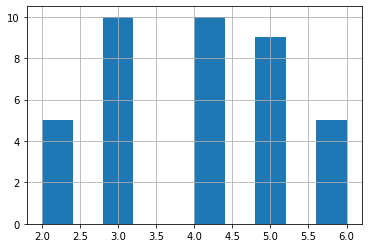

In [149]:
(df_age_dependence['age'] // 10).hist(bins=10);

Группировка по возрастам с разницей в год не дает необходимого для анализа результата из-за малого количества сотрудников, представленных в некоторых группах, и большого количества самих групп. Для более обощенных данных продолжим группировку по возрастным группам.

In [109]:
# query = """select
#   count(*) filter (where age < 35 ) as "25-34",
#   count(*) filter (where age >= 35 and age < 45) as "35-44",
#   count(*) filter (where age >= 45 and age < 55) as "45-54"
# from
#   hr_dataset;"""

In [136]:
query = """SELECT
             COUNT(age)
             , SUM("Days Employed")
             , MIN("Days Employed")
             , MAX("Days Employed")
             , AVG("Days Employed")
             , CASE
                 WHEN age < 35 THEN '25-34'
                 WHEN age >= 35 AND age < 45 THEN '35-44'
                 WHEN age >= 45 AND age < 55 THEN '45-54'
                 ELSE '55+'
               END "age groups"
           FROM hr_dataset
           GROUP BY "age groups"
           ORDER BY "age groups";
        """
df_ages_group_dependence = pd.read_sql(query, conn)
df_ages_group_dependence

,count,sum,min,max,avg,age groups
0,124,150058,6,3611,1210.145161,25-34
1,110,153063,2,3674,1391.481818,35-44
2,61,81168,2,4339,1330.622951,45-54
3,15,17496,98,1973,1166.400000,55+


In [138]:
query = """SELECT
             max("Date of Hire" + "Days Employed"  * INTERVAL '1 day')
           FROM hr_dataset;
        """
cursor.execute(query)
row = cursor.fetchone()
conn.commit()
print("Последняя дата обновления данных в таблице hr_dataset: %s" % row)

Последняя дата обновления данных в таблице hr_dataset: 2017-11-26 00:00:00


Данные действительны на дату 26 ноября 2017 года.


В целом зависимость продолжительности работы в компании от возраста существует, но не значительная. Средние показатели групп укладываются в срок от 3 до 4 лет. Разница в группах составила около 9 месяцев. Но группа 50+ с минимальным средним значением состоит из 15 человек, что в 7 с лишним раз меньше, чем количество сотрудников в группе 35-44 с наибольшим средним значением. Для более достоверных выводов требуется больше данных &mdash; большее количество участников выборки, особенно в группах 45-54 и 55+.

## 4. Есть ли зависимость между количеством привлеченных сотрудников и продолжительностью их работы в компании от источника и бюджета на привлечение?

Есть две таблицы `hr_dataset` и `recruiting_costs`. В первой есть данные о сотрудниках, во второй данные о стоимости привлечения за отчетный период (год). Год не указан, но если маркетинговая политика в отношении привлечения сотрудников не изменялась в течение нескольких лет, мы можем проанализировать, зависит ли срок службы сотрудников от привлечения через платный или бесплатный источник, и если источник платный, какое влияние оказывает стоимость привлечения.

Перед слиянием двух таблиц `hr_dataset` и `recruiting_costs` по полям `Employee Source` и `Employment Source` проверим отличие в содержании каждого из них.

In [169]:
query = """(SELECT DISTINCT "Employee Source"
           FROM hr_dataset
           EXCEPT
           SELECT "Employment Source"
           FROM recruiting_costs)
           UNION
           (SELECT "Employment Source"
           FROM recruiting_costs
           EXCEPT
           SELECT DISTINCT "Employee Source"
           FROM hr_dataset);
         """
df_employment_source_dif = pd.read_sql_query(query, conn)
df_employment_source_dif

,Employee Source
0,Indeed


Отличием является лишь один источник привлечения `Indeed`, который встречается в таблице `hr_dataset` и отсутствует в `recruiting_costs`. Чтобы учесть все источники, объединим таблицы с помощью `left outer join`.

In [172]:
query = """SELECT
             DISTINCT hr."Employee Source" AS "Employee Source"
             , COUNT(hr."Employee Name") AS "Number of Employees"
             , ROUND(AVG("Days Employed"), 0) AS "AVG Days Employed"
             , '' || date_trunc('month',
                               AVG(AGE(("Date of Hire" + "Days Employed" * INTERVAL '1 day'),
                               "Date of Hire"))) AS "AVG Terms Employed"
             , rec."Total" AS "Total Costs"
           FROM hr_dataset AS hr
           LEFT OUTER JOIN recruiting_costs AS rec
             ON hr."Employee Source" = rec."Employment Source"
           GROUP BY 1, 5
           ORDER BY 1
         """
df_employee_count_costs = pd.read_sql(query, conn)
df_employee_count_costs

,Employee Source,Number of Employees,AVG Days Employed,AVG Terms Employed,Total Costs
0,Billboard,16,1681.0,4 years 6 mons,6192.0
1,Careerbuilder,1,2428.0,6 years 7 mons,7790.0
2,Company Intranet - Partner,1,444.0,1 year 2 mons,0.0
3,Diversity Job Fair,29,1340.0,3 years 7 mons,10021.0
4,Employee Referral,31,1252.0,3 years 4 mons,0.0
5,Glassdoor,14,1135.0,3 years,0.0
6,Indeed,8,308.0,9 mons,NaN
7,Information Session,4,1552.0,4 years 2 mons,0.0
8,Internet Search,6,1274.0,3 years 5 mons,0.0
9,MBTA ads,17,1580.0,4 years 3 mons,10980.0


В представленных результатах выборки уже видно, что не все платные источники хорошо работают на привлечение, тем не менее в целом количество привлеченных сотрудников выше, если источник платный.

Например, с помощью Careerbuilder привлечен один сотрудник, а бюджет на привлечение только за отчетный период составил 7790 долларов. Тем не менее сотрудник проработал почти семь лет, что в два раза выше средних показателей. Возможно это того стоило.

Источник Indeed, который в отчетном периоде отсутствует в списках подрядной организации, привлек 8 человек, однако средний срок службы их составил всего 10 месяцев. Возможно это и стало причиной отказа от услуг компании в отчетном году.

Pay Per Click и Pay Per Click - Google, источники привлечения с интернет-ресурсов по оплате за клик (скорее всего контекстная реклама) показали противоположные результаты. Если в первом случае привлечено всего 2 человека, которые проработали всего два дня (0 месяцев). Во втором случае привлечен 21 человек (что в 10 раз больше) и со средним сроком службы 3,5 года. При этом сумма затрат в год на этот источник только менее трех раз превышает затраты на первый. Но есть Professional Society, которая привлекла 20 человек за годовой бюджет 1200 долларов, даже меньший, чем через Pay Per Click.

Стоит отметить полезность реферальной программы Vendor Referral (привлечение сотрудников по рекомендациям) и Word of Mouth (за счет репутации компании), с помощью которых удалось бесплатно привлечь 28 сотрудников, которые в среднем проработали почти три года. Социальные сети (Social Networks - Facebook Twitter etc) с годовым бюджетом 5,5 тыс. долларов привлекли за все время 11 человек, которые в среднем проработали около трех лет, что чуть меньше средних показателей.

Больше всего сотрудников (29) привлекла Diversity Job Fair, которой в год заплатили 10 тыс. долларов. Почти 11 тыс. долларов заплатили MBTA ads, которая привлекла 17 сотрудников. Но средний срок их службы на полтора года превышает средние показатели. В то же время Monster.com привлекла 24 сотрудника с превышающим средние показатели периодом работы и годовым бюджетом в два раза меньше.

# 2. Аналитический отчет для SMM-отдела

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox.

Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education).

Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа.

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [175]:
with open('vk_api_auth.json', 'r') as tkn:
    auth = json.loads(tkn.read())

In [191]:
TOKEN = auth['token']
V = auth['version']
GROUPID = 66669811

def vk(method, params=""):
    if params:
        params = "?%s" % '&'.join([f"{key}={value}" for key, value in params.items()])
    url = "https://api.vk.com/method/%s%s&access_token=%s&v=%s" % (method, params, TOKEN, V)
    data = requests.get(url).json()
    return data

Получаем последнюю запись из паблика Skillbox Вконтакте

In [179]:
vk('wall.get', {'owner_id': -GROUPID, 'count': 1})

{'response': {'count': 3333,
  'items': [{'id': 146593,
    'from_id': -66669811,
    'owner_id': -66669811,
    'date': 1612190809,
    'marked_as_ads': 0,
    'post_type': 'post',
    'text': 'Язык Go создавался для внутренних нужд Google, а теперь его используют в большинстве крупных компаний. И они неплохо платят разработчикам!\n\nРассказываем, в чём особенности этого языка и почему его непременно стоит выучить.\n\n#skillbox_программирование #статья_skillbox',
    'attachments': [{'type': 'link',
      'link': {'url': 'https://skillbox.ru/media/code/zachem_programmisty_izuchayut_go_kak_vtoroy_yazyk/?utm_source=skillbox.media&utm_medium=vk&utm_campaign=profession-godev&utm_content=articles&utm_term=whoisgodev',
       'title': 'Зачем программисты изучают Go как второй язык',
       'caption': 'skillbox.ru',
       'description': 'Язык Go создавался для внутренних нужд Google, а теперь его используют в большинстве крупных компаний. И они неплохо платят разработчикам.',
       'photo'

In [41]:
date = 1603206018
dt = (datetime.datetime.fromtimestamp(date)).strftime('%Y-%m-%d %H:%M:%S')
print(dt)

2020-10-20 18:00:18


Всего 3333 постов. Чтобы увидеть общую картину активности пользователей и потом выбрать отдельный период для анализа, выгрузим посты за все время.

In [187]:
def fetch_data(method, params, offset=100):
    result = []
    offset = offset
    count = vk(method=method, params=params)['response']['count']

    for _ in range(count // offset+1):
        response = vk(method=method, params=params)['response']
        result += response['items']
        params['offset'] += offset

    return result

In [192]:
params = dict(owner_id=-GROUPID, count=100, extended=1, offset=0)
posts = fetch_data("wall.get", params)

In [186]:
pd.to_datetime(1603292181, unit='s')

Timestamp('2020-10-21 14:56:21')

In [196]:
df = pd.json_normalize(posts)
df

,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,post_source.type,comments.count,...,likes.can_like,likes.can_publish,reposts.count,reposts.user_reposted,views.count,post_source.platform,copy_history,signer_id,post_source.url,post_source.data
0,146593,-66669811,-66669811,1612190809,0,post,"Язык Go создавался для внутренних нужд Google,...","[{'type': 'link', 'link': {'url': 'https://ski...",api,2,...,1,1,7,0,11533.0,NaN,NaN,NaN,NaN,NaN
1,146551,-66669811,-66669811,1612185197,0,post,Привет! На этой неделе научим писать электронн...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",api,0,...,1,1,16,0,12622.0,NaN,NaN,NaN,NaN,NaN
2,146545,-66669811,-66669811,1612177272,0,post,В рамках партнерской программы онлайн-универси...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",api,0,...,1,1,2,0,11782.0,NaN,NaN,NaN,NaN,NaN
3,146516,-66669811,-66669811,1612087011,0,post,"Мы знаем имена любимых писателей, режиссеров, ...","[{'type': 'photo', 'photo': {'album_id': -7, '...",api,3,...,1,1,39,0,20954.0,NaN,NaN,NaN,NaN,NaN
4,146492,-66669811,-66669811,1612020484,0,post,"Открываете Word, полчаса смотрите на чистый ли...","[{'type': 'photo', 'photo': {'album_id': -7, '...",api,0,...,1,1,170,0,24041.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,19003,-66669811,-66669811,1459681810,0,post,#internetmarketing #business #skillbox\n\n15 с...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",vk,0,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3330,18999,-66669811,-66669811,1459613053,0,post,#internetmarketing #business #skillbox\n\nБлес...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",vk,0,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3331,18998,-66669811,-66669811,1459595119,0,post,#movie #internetmarketing #business #skillbox ...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",vk,0,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3332,18994,-66669811,-66669811,1459515013,0,post,#studio #business #skillbox \n\n4 вида рекламн...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",vk,0,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3334 entries, 0 to 3333
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        3334 non-null   int64         
 1   from_id                   3334 non-null   int64         
 2   owner_id                  3334 non-null   int64         
 3   date                      3334 non-null   datetime64[ns]
 4   marked_as_ads             3334 non-null   int64         
 5   post_type                 3334 non-null   object        
 6   text                      3334 non-null   object        
 7   attachments               3290 non-null   object        
 8   post_source.type          3334 non-null   object        
 9   comments.count            3334 non-null   int64         
 10  comments.can_post         3334 non-null   int64         
 11  comments.groups_can_post  3334 non-null   bool          
 12  likes.count         

In [199]:
df['date'] = pd.to_datetime(df['date'], unit='s')

In [204]:
df = df[['id', 'date', 'text', 'likes.count', 'comments.count', 'reposts.count', 'views.count']]

In [46]:
df_changed_norm = json_normalize(changed)
df_changed_norm

,id,date,month_number,month,weekday,time,likes,reposts,comments,views,text
0,117226,2020-10-21 17:56:21,10,October,Wednesday,17,25,0,6,9121,Вы никогда не перепутаете «Магнит» с «Пятёрочк...
1,117219,2020-10-21 15:06:36,10,October,Wednesday,15,62,4,2,12743,"Окей, гугл, какая песня играет в моей голове?\..."
2,116802,2020-10-20 18:00:18,10,October,Tuesday,18,43,5,5,13131,"Давайте на спор: скорее всего, вы не знаете, ч..."
3,116666,2020-10-20 12:43:46,10,October,Tuesday,12,113,16,2,18039,Инстаграм и Фейсбук — эффективные площадки для...
4,116462,2020-10-19 19:00:27,10,October,Monday,19,50,5,2,16166,"Разбираемся, с чего начинать в программировани..."
...,...,...,...,...,...,...,...,...,...,...,...
3173,19003,2016-04-03 14:10:10,04,April,Sunday,14,4,0,0,0,#internetmarketing #business #skillbox\n\n15 с...
3174,18999,2016-04-02 19:04:13,04,April,Saturday,19,1,0,0,0,#internetmarketing #business #skillbox\n\nБлес...
3175,18998,2016-04-02 14:05:19,04,April,Saturday,14,3,0,0,0,#movie #internetmarketing #business #skillbox ...
3176,18994,2016-04-01 15:50:13,04,April,Friday,15,6,0,0,0,#studio #business #skillbox \n\n4 вида рекламн...


In [226]:
import seaborn as sns
sns.set(style="white", color_codes=True)

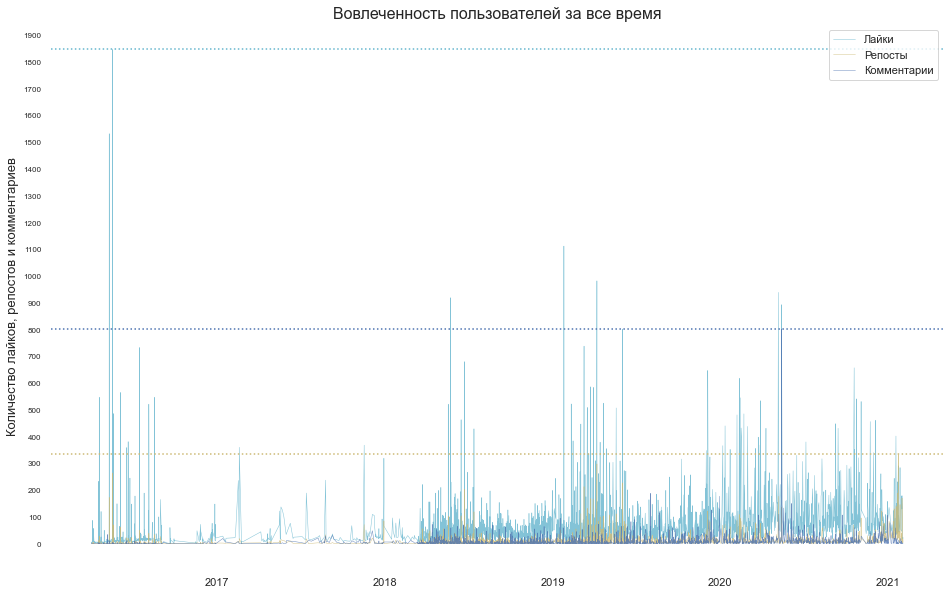

In [231]:
fig, ax = plt.subplots(figsize=(16,10))
ax.set(frame_on=False)
likes = plt.plot(df['date'], df['likes.count'], label='Лайки', color='c')
reposts = plt.plot(df['date'], df['reposts.count'], label='Репосты', color='y')
comments = plt.plot(df['date'], df['comments.count'], label='Комментарии', color='b')
plt.axhline(y=df['likes.count'].max(), ls=':', color='c')
plt.axhline(y=df['reposts.count'].max(), ls=':', color='y')
plt.axhline(y=df['comments.count'].max(), ls=':', color='b')
plt.setp([likes, reposts, comments], linewidth=0.5, alpha=.8)
plt.xlabel(None)
plt.ylabel('Количество лайков, репостов и комментариев', fontsize=13)
# plt.xticks(dates, labels = [pd.to_datetime(str(date)).strftime("%m.%d.%Y") for date in dates],
#                                                                rotation=45, ha='right', fontsize=8)
plt.yticks(range(0, round(df['likes.count'].max(), -2)+200, 100), fontsize=8)
plt.legend(loc='upper right')
plt.title('Вовлеченность пользователей за все время', fontsize=16)
plt.show()

На графике показана активность пользователей, выраженная количеством лайков, постов и комментариев. Численностью заметно преобладают лайки (медиана 35, макс. значение 1847 в мае 2016 года), далее идут репосты (медиана 3, макс. значение 301 в апреле 2019 года) и комментарии (медиана 1, макс. значение 802 в мае 2020 года).

За все время можно выделить три периода активности:
* С самого начала до августа 2016 года период неравномерной средней активности.
* С сентября 2016 года до середины марта 2018 года период слабой активности. Также попадает на тестовый период и начало полноценной работы платформы Skillbox. Из прошлой курсовой известно, что основная деятельность компании началась с января 2018 года.
* С середины марта 2018 по настоящее время период наибольшей активности. Рассмотрим его ближе.

In [233]:
df_active = df[df['date'] > '2018-3-1']
df_active.head()

,id,date,text,likes.count,comments.count,reposts.count,views.count
0,146593,2021-02-01 14:46:49,"Язык Go создавался для внутренних нужд Google,...",20,2,7,11533.0
1,146551,2021-02-01 13:13:17,Привет! На этой неделе научим писать электронн...,23,0,16,12622.0
2,146545,2021-02-01 11:01:12,В рамках партнерской программы онлайн-универси...,17,0,2,11782.0
3,146516,2021-01-31 09:56:51,"Мы знаем имена любимых писателей, режиссеров, ...",58,3,39,20954.0
4,146492,2021-01-30 15:28:04,"Открываете Word, полчаса смотрите на чистый ли...",179,0,170,24041.0


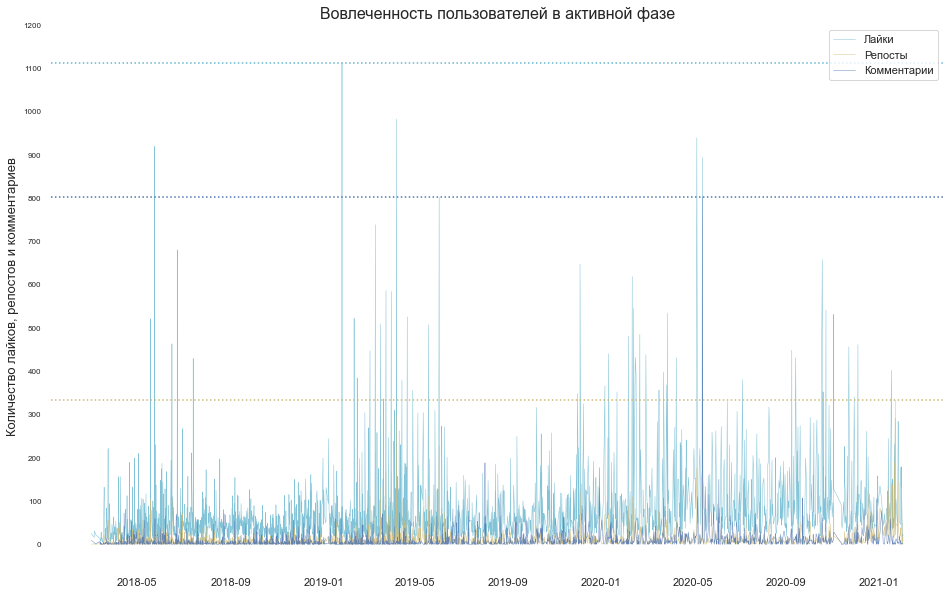

In [234]:
fig, ax = plt.subplots(figsize=(16,10))
ax.set(frame_on=False)
likes = plt.plot(df_active['date'], df_active['likes.count'], label='Лайки', color='c')
reposts = plt.plot(df_active['date'], df_active['reposts.count'], label='Репосты', color='y')
comments = plt.plot(df_active['date'], df_active['comments.count'], label='Комментарии', color='b')
plt.axhline(y=df_active['likes.count'].max(), ls=':', color='c')
plt.axhline(y=df_active['reposts.count'].max(), ls=':', color='y')
plt.axhline(y=df_active['comments.count'].max(), ls=':', color='b')
plt.setp([likes, reposts, comments], linewidth=0.5, alpha=.8)
plt.xlabel(None)
plt.ylabel('Количество лайков, репостов и комментариев', fontsize=13)
plt.yticks(range(0, round(df_active['likes.count'].max(), -2)+200, 100), fontsize=8)
plt.legend(loc='upper right')
plt.title('Вовлеченность пользователей в активной фазе', fontsize=16)
plt.show()

В этот период видна сезонная зависимость. Наибольшая активность пользователей приходится на весенние месяцы (и в начале лета 2018), наименьшая на осень. Однако к 2020 году влияние сезонов становится менее заметным из-за оптимизации SMM-маркетинга компании и, возможно, влияния макрофакторов. Поэтому для исследований предлагается выбрать годовой период с ноября прошлого года, как наиболее репрезентативный в новых реалиях.

In [248]:
df_active_year = df[df['date'].dt.year == 2020]
df_active_year

,id,date,text,likes.count,comments.count,reposts.count,views.count
46,142839,2020-12-31 16:00:51,Друзья! Весь год мы работали для вас: запускал...,105,0,12,37380.0
47,142835,2020-12-31 12:51:16,"Друзья, с наступающим Новым годом!\n\nПрежде ч...",102,5,16,39099.0
48,142571,2020-12-30 16:31:42,Сергей был продажником. Потом стал поваром. По...,88,16,53,31953.0
49,142468,2020-12-30 12:31:12,Вторая часть нашего гороскопа. Ищите прогноз н...,158,9,77,48013.0
50,142467,2020-12-30 12:28:52,"ОСТОРОЖНО, СПОЙЛЕРЫ!\n\nПосле непростого 2020-...",110,4,56,35476.0
...,...,...,...,...,...,...,...
672,48257,2020-01-08 09:10:27,Есть два типа людей:\n «Как же круто я отдохну...,26,28,0,17836.0
673,48213,2020-01-06 16:00:29,"Ждете, когда работа сама найдет вас? Сделайте ...",115,8,16,20049.0
674,48209,2020-01-06 10:42:49,"Удивляетесь, когда слышите про выученные наизу...",366,0,69,56692.0
675,48181,2020-01-04 08:30:42,"Новый год встречен, подарки розданы, салаты съ...",101,2,4,38233.0


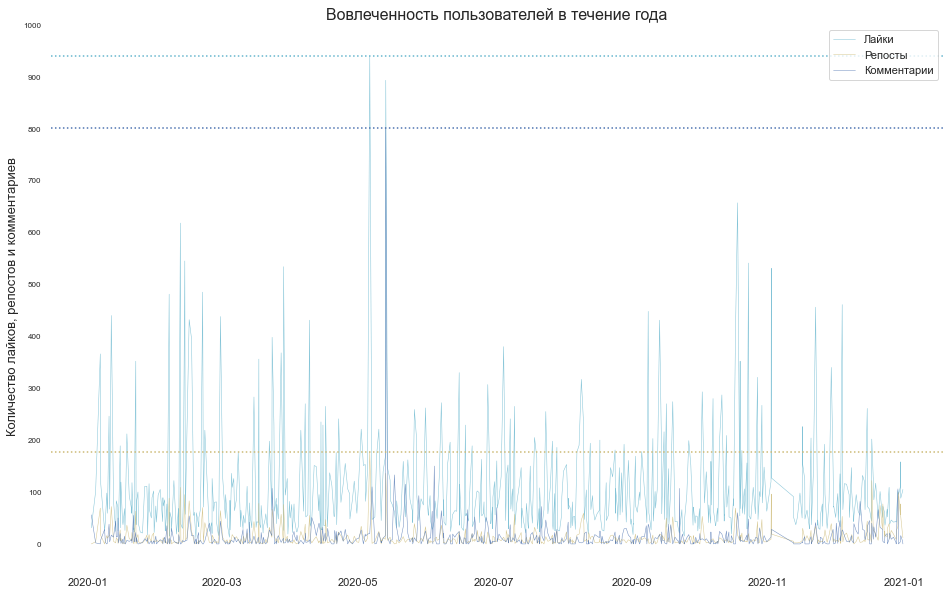

In [249]:
fig, ax = plt.subplots(figsize=(16,10))
ax.set(frame_on=False)
likes = plt.plot(df_active_year['date'], df_active_year['likes.count'], label='Лайки', color='c')
reposts = plt.plot(df_active_year['date'], df_active_year['reposts.count'], label='Репосты', color='y')
comments = plt.plot(df_active_year['date'], df_active_year['comments.count'], label='Комментарии', color='b')
plt.axhline(y=df_active_year['likes.count'].max(), ls=':', color='c')
plt.axhline(y=df_active_year['reposts.count'].max(), ls=':', color='y')
plt.axhline(y=df_active_year['comments.count'].max(), ls=':', color='b')
plt.setp([likes, reposts, comments], linewidth=0.5, alpha=.8)
plt.xlabel(None)
plt.ylabel('Количество лайков, репостов и комментариев', fontsize=13)
plt.yticks(range(0, round(df_active_year['likes.count'].max(), -2)+200, 100), fontsize=8)
plt.legend(loc='upper right')
plt.title('Вовлеченность пользователей в течение года', fontsize=16)
plt.show()

In [250]:
pd.concat([df_active_year['likes.count'].describe().astype(int), 
           df_active_year['reposts.count'].describe().astype(int),
           df_active_year['comments.count'].describe().astype(int),
           df_active_year['views.count'].describe().astype(int)], axis=1)

,likes.count,reposts.count,comments.count,views.count
count,631,631,631,631
mean,101,11,13,24854
std,105,18,36,10242
min,12,0,0,9728
25%,42,3,2,19228
50%,66,6,6,22749
75%,116,13,16,28301
max,939,177,802,92157


In [252]:
df_active_year_by_months = df_active_year \
                        .groupby(df_active_year.date.dt.month)[['likes.count',
                                                                'reposts.count','comments.count']] \
                        .agg(['median', 'sum'])
df_active_year_by_months

likes.count       reposts.count       comments.count      
          median   sum        median   sum         median   sum
date                                                           
1           67.5  4648           7.0   623            6.0   553
2           62.0  6486           4.5   845            5.0   464
3           57.0  5533           6.0   706            4.0   532
4           63.5  4898           4.5   483            8.0   673
5           87.0  5940           8.0   669           12.0  1667
6           58.0  4833           5.0   457            7.5   846
7           68.5  5410           5.0   523            6.0   653
8           67.0  5085           6.0   499            5.0   467
9           61.0  5108           5.0   434            7.0   582
10          74.0  7090           6.0   553            7.0   547
11          71.5  4048           6.0   469            2.5   255
12          69.5  5228          12.5  1273           13.0  1083

In [256]:
df_active_year_by_months['likes.count', 'median']

date
1     67.5
2     62.0
3     57.0
4     63.5
5     87.0
6     58.0
7     68.5
8     67.0
9     61.0
10    74.0
11    71.5
12    69.5
Name: (likes.count, median), dtype: float64

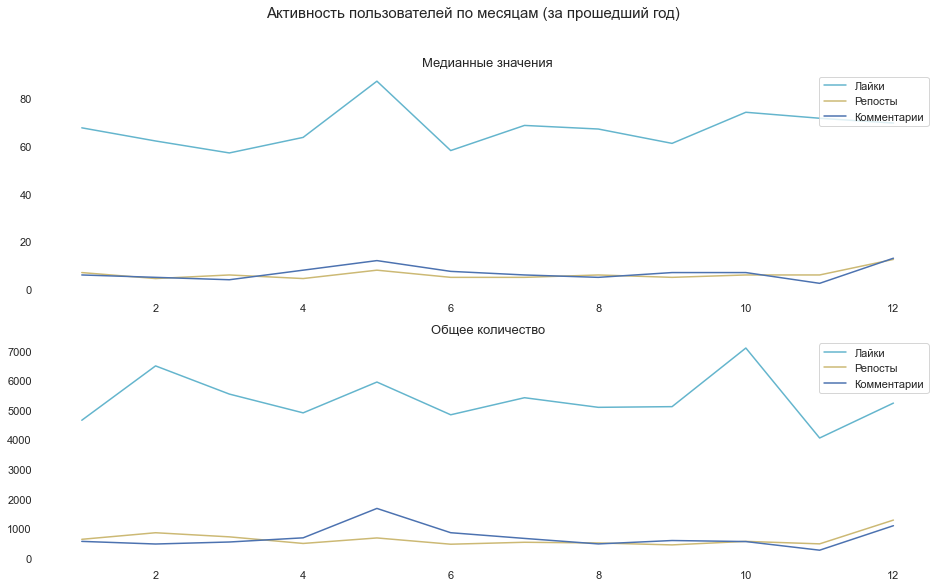

In [261]:
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
figure.suptitle('Активность пользователей по месяцам (за прошедший год)', fontsize=15)
ax[0].set(frame_on=False)
ax[0].set_title('Медианные значения', fontsize=13)
ax[0].plot(df_active_year_by_months.index, 
                df_active_year_by_months['likes.count', 'median'], label='Лайки', color='c')
ax[0].plot(df_active_year_by_months.index,
                df_active_year_by_months['reposts.count', 'median'], label='Репосты', color='y')
ax[0].plot(df_active_year_by_months.index,
                df_active_year_by_months['comments.count', 'median'], label='Комментарии', color='b')
ax[0].legend(loc = 'upper right')
ax[1].set(frame_on=False)
ax[1].set_title('Общее количество', fontsize=13)
ax[1].plot(df_active_year_by_months.index,
                df_active_year_by_months['likes.count', 'sum'], label='Лайки', color='c')
ax[1].plot(df_active_year_by_months.index,
                df_active_year_by_months['reposts.count', 'sum'], label='Репосты', color='y')
ax[1].plot(df_active_year_by_months.index,
                df_active_year_by_months['comments.count', 'sum'], label='Комментарии', color='b')
ax[1].legend(loc = 'upper right')

plt.show()

Максимальная активность по всем медианным значениям зафиксирована в мае 2020 года: 86 у лайков, 7 у репостов, 12 у комментариев. При этом по общему количеству лайков (6455) и репостов (835) в месяц лидирует февраль. В декабре 2019 года суммарные значения также относительно высоки: 6039 лайков, 759 репостов, 964 комментариев. Это говорит о том, что в декабре и феврале было больше по количеству постов с меньшим количеством лайков, репостов и комментариев, чем в мае. То есть в мае активность пользователей была выше, не смотря на меньшее количество постов, что подтверждает вывод ниже (всего 39 постов при 60 и 56 в декабре и феврале соответственно).

Скорее всего всплески активности носят сезонный характер, связанный с маркетинговыми стимулирующими кампаниями в преддверии новогодних (декабрь), гендерных (февраль) праздников, и поддержанием спроса перед началом лета (май).

In [254]:
df_active_year_count_by_months = df_active_year.groupby(df_active_year.date.dt.month)[['id']].agg(['count'])
df_active_year_count_by_months

,id
,count
date,
1,52
2,56
3,59
4,50
5,39
6,58
7,60
8,55


In [263]:
#cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_active_year_by_weekdays = df_active_year \
                                    .groupby(df_active_year.date.dt.weekday)[['likes.count',
                                                                              'reposts.count', 'comments.count']] \
                                    .agg(['median', 'sum'])
df_active_year_by_weekdays

likes.count        reposts.count       comments.count      
          median    sum        median   sum         median   sum
date                                                            
0           64.5  10898           5.0  1228            6.0  1365
1           55.0   9444           6.0  1260            5.0  1173
2           56.5  10271           6.0  1372            6.0  1952
3           61.0   9065           5.0  1146            5.0  1200
4           68.0   8542           7.0   916            6.0  1065
5          116.5   7356           8.5   855            8.5   706
6          131.0   8731          12.5   757           11.0   861

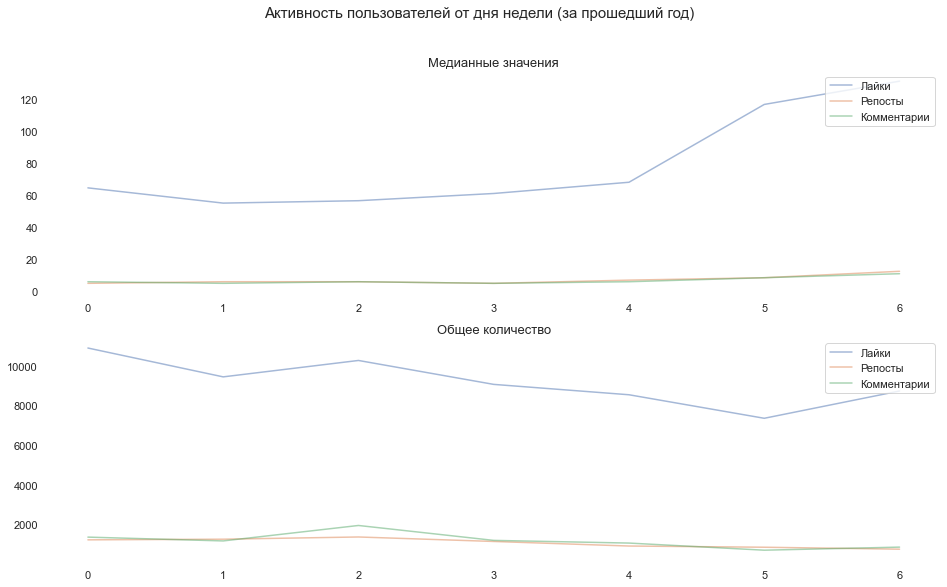

In [317]:
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
figure.suptitle('Активность пользователей от дня недели (за прошедший год)', fontsize=15)

ax[0].set(frame_on=False)
ax[0].set_title('Медианные значения', fontsize=13)
df_active_year_by_weekdays.loc[:, (slice(None), "median")].plot(ax=ax[0], alpha=0.5)
ax[0].legend(['Лайки', 'Репосты', 'Комментарии'], loc='upper right')
ax[0].set_xlabel(None)

ax[1].set(frame_on=False)
ax[1].set_title('Общее количество', fontsize=13)
df_active_year_by_weekdays.loc[:, (slice(None), "sum")].plot(ax=ax[1], alpha=0.5)
ax[1].legend(['Лайки', 'Репосты', 'Комментарии'], loc='upper right')
ax[1].set_xlabel(None)
plt.show()

In [331]:
df_active_year_count_by_weekdays = df_active_year \
                            .groupby(df_active_year.date.dt.weekday)[['id']] \
                            .agg(['count'])
count_by_weekdays_median = int(df_active_year_count_by_weekdays.median())

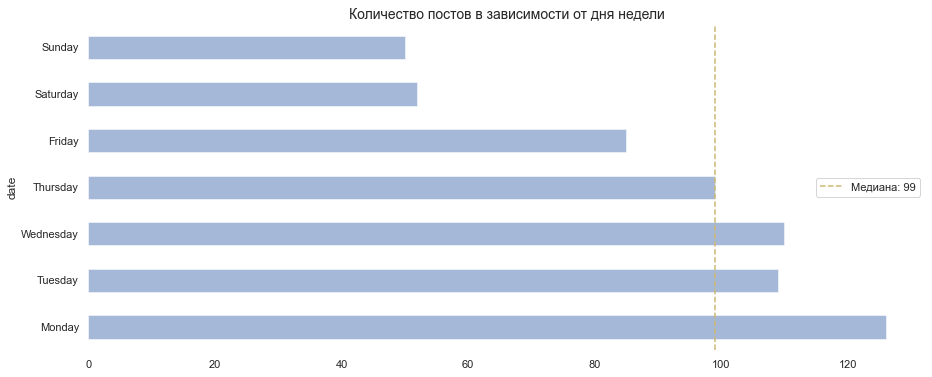

In [364]:
figure, ax = plt.subplots(figsize=(15, 6))
df_active_year_count_by_weekdays.plot(ax=ax, kind='barh', alpha=0.5)
ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.axvline(x = count_by_weekdays_median, ls='--', color='y')
plt.title('Количество постов в зависимости от дня недели', size=14)
plt.legend(['Медиана: {}'.format(count_by_weekdays_median), ], loc='center right')
plt.box(on=False)
plt.show()

На графиках выше мы видим обратно пропорциональную зависимость медианных значений активности к количеству размещаемых постов. Чем меньше размещаемых постов, тем больше активности на каждый из них. Количество размещаемых постов в выходные падает более чем вдвое (пн.: 128, сб. и вс.: 53), тем временем к воскресенью медианы активностей практически удваиваются. На общем количестве лайков, респостов и комментариев это сказывается не так заметно, но есть выраженные пики в понедельник и среду (сравнительная таблица со средними значениями представлена ниже).

In [349]:
df_active_year_by_weekdays.loc[:, (slice(None), 'sum')].agg(['max', 'mean']) \
                    .rename(index={'max' : 'Wednesday', 'mean' : 'All weekdays mean'})

,likes.count,reposts.count,comments.count
,sum,sum,sum
Wednesday,10898.000000,1372.000000,1952.000000
All weekdays mean,9186.714286,1076.285714,1188.857143


In [353]:
df_active_year_by_hours = df_active_year \
                                        .groupby(df_active_year.date.dt.hour)[
                                        ['likes.count', 'reposts.count', 'comments.count']] \
                                        .agg(['median', 'sum'])
df_active_year_by_hours.index.name = 'hours'
df_active_year_by_hours

likes.count        reposts.count       comments.count      
           median    sum        median   sum         median   sum
hours                                                            
7            61.5    750           5.5    90           18.5   174
8           108.0  11075           7.5  1175           10.0  1337
9           101.0  12597           9.0  1552           11.0  1525
10           86.0   7106           5.0   651            8.0  1085
11           67.0   6087           6.0   439            7.5   660
12           70.5   4750           5.0   610            5.0   448
13           65.0   4288           6.0   477            4.0  1278
14           58.0   4521           5.5   581            3.5   351
15           53.0   5726           5.0   849            4.0   699
16           63.5   4997           8.0   827            4.0   511
17           54.5   2170           5.0   269            3.0   201
18           66.0    240           5.0    14           13.0    53

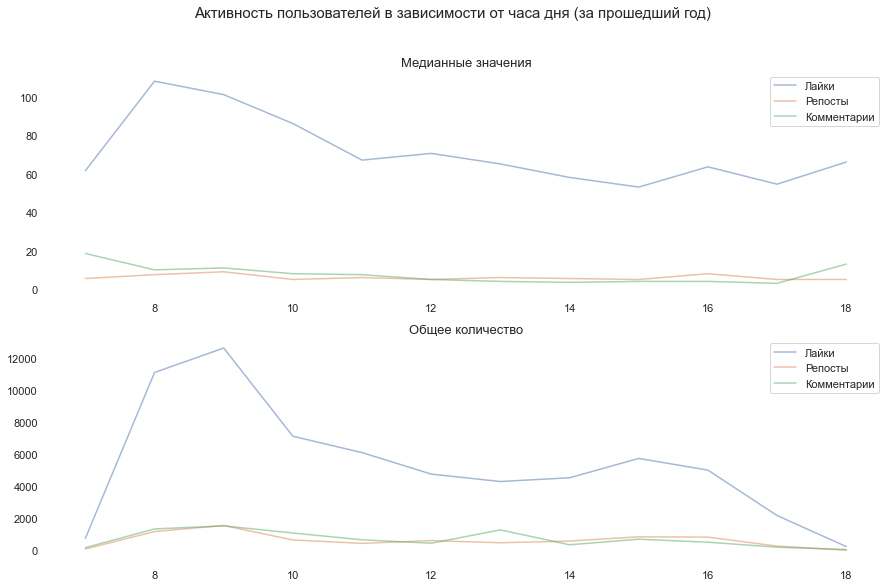

In [354]:
figure, ax = plt.subplots(2, 1, figsize=(15, 9))
figure.suptitle('Активность пользователей в зависимости от часа дня (за прошедший год)', fontsize=15)

ax[0].set(frame_on=False)
ax[0].set_title('Медианные значения', fontsize=13)
df_active_year_by_hours.loc[:, (slice(None), "median")].plot(ax=ax[0], alpha=0.5)
ax[0].legend(['Лайки', 'Репосты', 'Комментарии'], loc='upper right')
ax[0].set_xlabel(None)

ax[1].set(frame_on=False)
ax[1].set_title('Общее количество', fontsize=13)
df_active_year_by_hours.loc[:, (slice(None), "sum")].plot(ax=ax[1], alpha=0.5)
ax[1].legend(['Лайки', 'Репосты', 'Комментарии'], loc='upper right')
ax[1].set_xlabel(None)
plt.show()

In [355]:
df_active_year_count_by_hours = df_active_year \
                                      .groupby(df_active_year.date.dt.hour)[['id']].agg(['count'])
count_by_hours_median = int(df_active_year_count_by_hours.median())

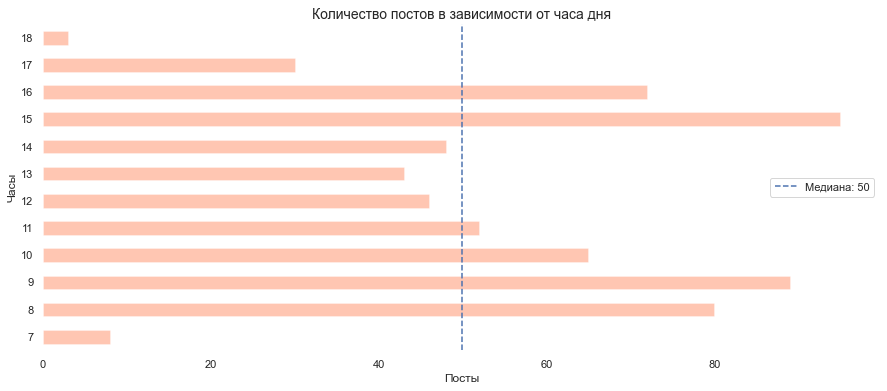

In [363]:
figure, ax = plt.subplots(figsize=(15, 6))
df_active_year_count_by_hours.plot(ax=ax, kind='barh', color='orangered', alpha=0.3)
plt.axvline(x=count_by_hours_median, ls='--', color='b')
plt.title('Количество постов в зависимости от часа дня', size=14)
plt.ylabel('Часы', fontsize=12)
plt.xlabel('Посты', fontsize=12)
plt.legend(['Медиана: {}'.format(count_by_hours_median), ], loc='center right')
plt.box(on=False)
plt.show()

Здесь мы видим корреляцию графиков активности и количества выложенных постов в зависимости от часа дня.

За отчетный период посты выкладывались с 8 утра до 22 часов вечера. Отчетливо видны пики с 11 до 13 (91-107 постов) и с 18 до 19 (86 постов) часов.

Наиболее высока активность в первой половине дня с 11 до 14 часов. Менее выраженный пик активности наблюдается в районе 18-20 часов вечера. При этом еще есть участок повышенной активности с 16 до 17 часов, который не учитывается при размещении постов.

Также замечены поведенческие особенности пользователей (из-за малого количества данные требуют дополнительной проверки): в утренние часы с 8 до 10 утра часто на каждый пост ставят лайки и делают репосты, а с 9 до 11 активность смещается в пользу комментариев.

*Можно рекомендовать увеличить количество размещений постов в выходные дни. Сдвинуть часть размещаемых постов после 17 часов на час ранее (с 16 до 17). Желательно поэкспериментировать с размещением постов с 21 до 24 часов, учитывая особенности "работы до поздна" креативного класса, на который ориентирована платформа.*

In [365]:
df_programming = df_active_year[df_active_year['text'].str.contains('#Skillbox_Программирование')]
df_programming

,id,date,text,likes.count,comments.count,reposts.count,views.count
78,134231,2020-12-14 16:07:41,"Илья, начинающий программист, написал программ...",66,8,4,27115.0
99,129002,2020-12-02 15:29:30,"Павел занимался гончарным делом, открыл в Моск...",42,24,4,25704.0
100,129002,2020-12-02 15:29:30,"Павел занимался гончарным делом, открыл в Моск...",42,24,4,25704.0
137,120222,2020-11-02 16:00:34,"Главный закон веб-разработки: “То, что выгляди...",127,28,19,79062.0
160,116462,2020-10-19 16:00:27,"Разбираемся, с чего начинать в программировани...",68,5,5,23963.0
195,100940,2020-09-30 15:00:09,Комментировать свой код — обязательный навык п...,25,4,3,18816.0
207,99820,2020-09-23 16:54:48,Удивительное дело: компьютерный вирус в 1994 г...,28,19,3,20563.0
217,98539,2020-09-17 15:53:25,"""Смертельная инъекция"" — звучит жутко, правда?...",38,4,4,21404.0
234,94587,2020-09-08 15:42:14,Максим не смог стать программистом в университ...,60,34,1,21860.0
236,94108,2020-09-07 18:03:31,"Мобильный разработчик — это тот, который быстр...",41,0,5,21077.0


За отчетный период размещено 17 постов с тегом #Skillbox_Программирование, 5 в июне, 6 в сентябре, по одному в августе и октябре, 3 в последнем месяце года.

In [366]:
main_text = []
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)
for raw_text in df_programming.text.values:
    raw_text_lower = raw_text.lower()
    text_by_words = reg_expr_compiled.findall(raw_text_lower)
    main_text += text_by_words

In [367]:
morph = pymorphy2.MorphAnalyzer()
normalized_text = []
for word in main_text:
    parsed_token = morph.parse(word)
    normal_form = parsed_token[0].normal_form
    normalized_text.append(normal_form)

In [368]:
df_words = pd.DataFrame(normalized_text, columns=['words'])
df_words_count = df_words.assign(count = 1).groupby('words').sum().sort_values(by='count', ascending=False)

In [372]:
pos = {'INTJ', 'PRCL', 'CONJ', 'PREP', 'NPRO', 'UNKN'}
words_list = df_words_count.index.tolist()
words_list_trimmed = [word for word in words_list if morph.parse(word)[0].tag.POS in pos] \
       + ['skillbox_программирование', 'статья_skillbox', 'vk', 'cc',
          'https', 'свой', 'самый', 'тот', 'весь', 'который', 'этот',
          'сам', 'наш', 'можно', 'мочь', 'вскоре', 'где', 'теперь', 'ещё']
df_words_count_trimmed = df_words_count.loc[~df_words_count.index.isin(words_list_trimmed)]

In [373]:
df_words_count_trimmed[df_words_count_trimmed['count'] > 2]

,count
words,
игра,9
курс,7
работать,6
рассказывать,6
мобильный,6
программист,5
код,5
какой,4
сайт,4


В текстах постов про программирование чаще всего используется слово «игра». Три и более раз встречаются обычные для темы слова, такие как «программист», «разработчик», «программирование», «язык». Слова «мобильный» (речь идет о мобильных приложениях) и «игра» самые популярные, отражающие тенденции в современной разработке. Также часто видны призывы «почитать», «стать», «сделать», «работать», которые в сочетании с популярностью слова «курс» говорят о маркетинговой составляющей текстов, стимулирующих к взаимодействию и приобретению.